## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

from tomo_encoders import Patches
from params import model_path, get_model_params
from datasets import dataset_names, get_datasets
from tomo_encoders.rw_utils.data_pairs import load_dataset_pairs
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.misc.img_stats import calc_jac_acc
from cupyx.scipy.ndimage import zoom
import cupy as cp

In [2]:
model_tag = "M_a02"
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}
model_params = get_model_params(model_tag)
patch_size = (32,32,32)


 ####################################################### 


Model is M_a02
n_filters [16, 32]
n_blocks 2
activation lrelu
batch_norm True
isconcat [True, True]
pool_size [2, 4]


In [3]:
fe = SurfaceSegmenter(model_initialization = 'load-model', \
                     model_names = model_names, \
                     model_path = model_path)    
fe.test_speeds(128,n_reps = 5, input_size = patch_size)

inf. time per patch (32, 32, 32) = 18.27 ms, nb = 128
inf. time per voxel 557.69 ns


inf. time per patch (32, 32, 32) = 2.37 ms, nb = 128
inf. time per voxel 72.44 ns


inf. time per patch (32, 32, 32) = 2.32 ms, nb = 128
inf. time per voxel 70.85 ns


inf. time per patch (32, 32, 32) = 2.73 ms, nb = 128
inf. time per voxel 83.28 ns


inf. time per patch (32, 32, 32) = 2.29 ms, nb = 128
inf. time per voxel 70.00 ns




In [4]:
fpath_x = '/data02/MyArchive/aisteer_3Dencoders/tmp_data/test_x_rec'
fpath_y = '/data02/MyArchive/aisteer_3Dencoders/tmp_data/test_y'
ds_x = DataFile(fpath_x, tiff = True)
ds_y = DataFile(fpath_y, tiff = True)
Vx = ds_x.read_full()
Vy = ds_y.read_full()
VOL_SHAPE = Vx.shape


##################################################
Found existing tiff folder: test_x_rec
Dataset shape: (896, 2176, 2176)

##################################################
Found existing tiff folder: test_y
Dataset shape: (896, 2176, 2176)


In [5]:
def vis_segmentation(vx, vp, vy):
    imx = viewer.get_orthoplanes(vol = vx)
    imp = viewer.get_orthoplanes(vol = vp)
    imy = viewer.get_orthoplanes(vol = vy)
    fig, ax = plt.subplots(1,1,figsize = (16,16))
    viewer.edge_plot(imx[0], imp[0], ax)
    ax.imshow(np.sqrt((imy[0]-imp[0])**2), cmap = 'copper', alpha = 0.5)
    return

In [6]:
def segment_volume(vx, patch_size, batch_size, binning = 0, norm_sampling_fac = 4):
    t00 = time.time()
    ## ASSUMES v has dimensions that are a multiple of the patch_size !!
    ORIG_SHAPE = vx.shape
    vp = np.zeros(ORIG_SHAPE, dtype=np.uint8)
    _s = tuple([slice(None, None, norm_sampling_fac)]*3)
    min_max = vx[_s].min(), vx[_s].max()
    
    if binning > 0:
        vx = vx[::2**binning,::2**binning,::2**binning]
    
    print("\n")
    print(f"psize: {patch_size}; bsize: {batch_size}")
    p_sel = Patches(vx.shape, initialize_by='regular-grid', patch_size = patch_size)
    x = p_sel.extract(vx, patch_size)
    print(f"input to U-net: {x.shape}")
    x = fe.predict_patches("segmenter", x[...,np.newaxis], batch_size, None, min_max = min_max)[...,0]
    
    if binning > 0:
        t0_zoom = time.time()
        x = np.asarray([zoom(cp.array(_x),2**binning, mode = 'constant', order = 1).get() for _x in x])    
        p_sel = p_sel.rescale(2**binning, ORIG_SHAPE)
        print(f'time for cupy zoom: {time.time() - t0_zoom:.2f} secs')
    
    
    p_sel.fill_patches_in_volume(x, vp)
    t11 = time.time()
    print(f"time for segmentation: {(t11 - t00):.2f} seconds")
    return vp

In [7]:
batch_size = 256
Vp = segment_volume(Vx, patch_size, batch_size, binning = 2)
print(f"IoU accuracy w.r.t ref. GT: {calc_jac_acc(Vy, Vp):.5f}")



psize: (32, 32, 32); bsize: 256
input to U-net: (2023, 32, 32, 32)
time for cupy zoom: 4.42 secs
time for segmentation: 11.41 seconds
IoU accuracy w.r.t ref. GT: 0.97107


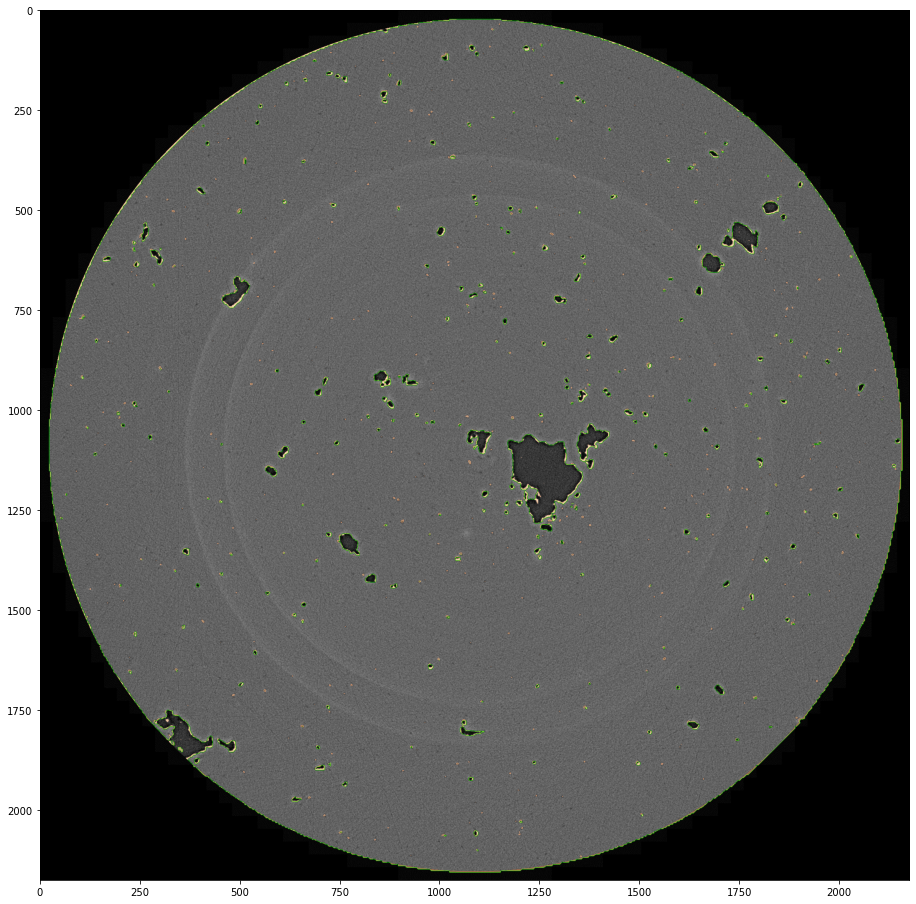

In [8]:
vis_segmentation(Vx, Vp, Vy)

In [9]:
imx = viewer.get_orthoplanes(vol = Vx)
imp = viewer.get_orthoplanes(vol = Vp)
imy = viewer.get_orthoplanes(vol = Vy)

In [10]:
def segment_surface(vx, vp, patch_size, batch_size, norm_sampling_fac = 4):
    t00 = time.time()
    
    # improve segmentation on the surface voxels
    p_surf = Patches(vp.shape, initialize_by='regular-grid', patch_size=patch_size)
    edge_mask = np.std(p_surf.extract(vp,tuple(np.asarray(patch_size)//4)),axis = (1,2,3)) > 0
    eff = edge_mask.sum()/edge_mask.size
    print(f"voxels in the neighborhood of surface: {eff*100.0:.2f} pc of total")    
    
    
    p_surf = p_surf.filter_by_condition(edge_mask)
    x_surf = p_surf.extract(vx, patch_size)
    
    # normalization
    _s = tuple([slice(None, None, norm_sampling_fac)]*3)
    min_max = vx[_s].min(), vx[_s].max()
    
    # pass through U-net and fill into coarsely segmented volume
    print(f"input to U-net: {x_surf.shape}")
    x_surf = fe.predict_patches("segmenter", x_surf[...,np.newaxis], batch_size, None, min_max = min_max)[...,0]
    p_surf.fill_patches_in_volume(x_surf, vp)
    
    t11 = time.time()
    print(f"time for segmentation: {(t11 - t00):.2f} seconds")
    return vp, p_surf

In [11]:
batch_size = 256
Vp, p_surf = segment_surface(Vx, Vp, patch_size, batch_size)
print(f"IoU accuracy w.r.t ref. GT: {calc_jac_acc(Vy, Vp):.5f}")

voxels in the neighborhood of surface: 21.37 pc of total
input to U-net: (27673, 32, 32, 32)
time for segmentation: 72.50 seconds
IoU accuracy w.r.t ref. GT: 0.99208


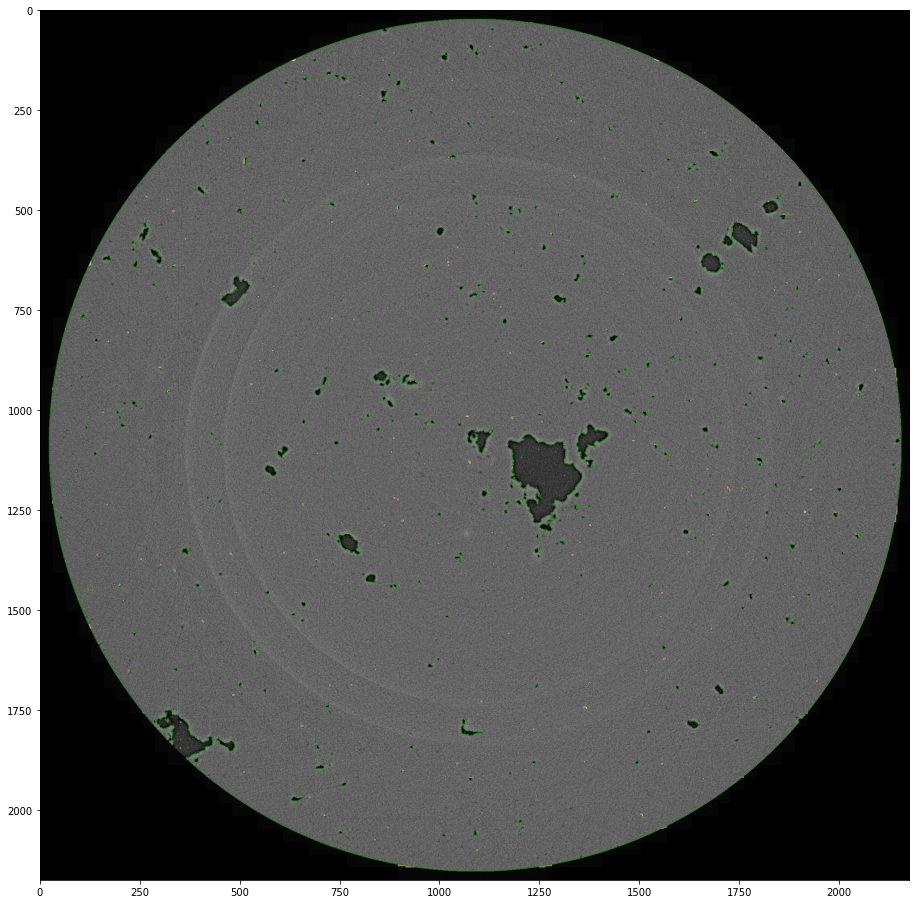

In [12]:
vis_segmentation(Vx, Vp, Vy)

In [13]:
m_surf = np.ones(((len(p_surf),) + patch_size), dtype = np.uint8)
Vm = np.zeros(Vp.shape, dtype = np.uint8)
p_surf.fill_patches_in_volume(m_surf, Vm)

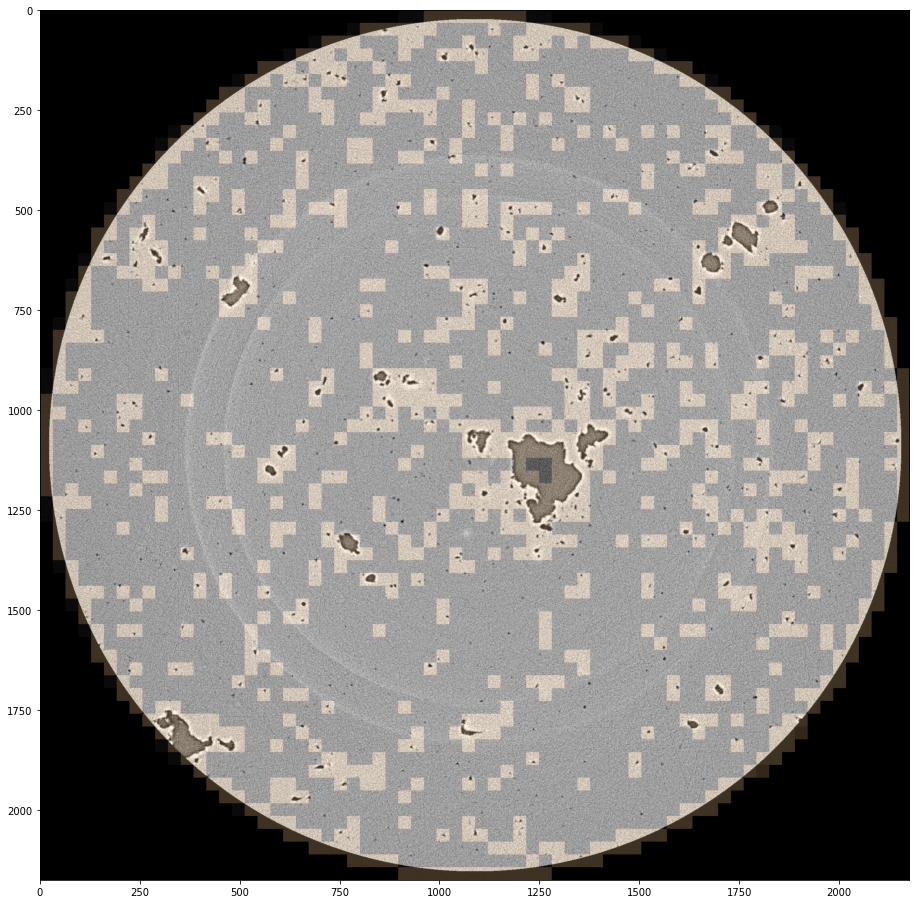

In [14]:
imx = viewer.get_orthoplanes(vol = Vx)
imm = viewer.get_orthoplanes(vol = Vm)
fig, ax = plt.subplots(1,1,figsize = (16,16))
ax.imshow(imx[0], cmap = 'gray')
ax.imshow(imm[0], cmap = 'copper', alpha = 0.2)

## TRASH

In [15]:
# cylindrical_mask(Vx, 0.98, mask_val = 0.0)